In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from PIL import Image
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from albumentations.pytorch import ToTensorV2
from fixpoint_utils import (
    keypoints_IoU_mult,
    get_acc, 
    save_checkpoint, 
    load_checkpoint, 
    get_loader_keypoint)
from Keypoint_dataset_poisson import Keypoint_dataset_poisson

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from models_2 import ResNet, BasicBlock, KeypointModel, KeypointCNN, EfficentNet, EfficentNet_3, EfficentNet_4

In [2]:
import wandb
import os 

os.environ['WANDB_NOTEBOOK_NAME'] = 
%env WANDB_API_KEY = 

wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/alex/Documents/new try/Lung Unet/compare_models.ipynb.


env: WANDB_API_KEY=32ba2dfcae28d5229d9da5ea919130a28f8ab52c


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: alexander-ortlieb94 (ulm-university). Use `wandb login --relogin` to force relogin


True

In [3]:
# HYPERPARAMETERS:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOGGING = False
NUM_EPOCHS = 50
random.seed(42)
torch.manual_seed(42)

In [4]:
#train_loader, test_loader = get_loader_keypoint()

In [5]:
Keypoint_model = KeypointModel().to(device=DEVICE)
Keypoint_CNN = KeypointCNN(features=[16, 32, 64, 128]).to(device=DEVICE)
ResNet18 = ResNet(img_channels = 1 ,num_layers = 18, block = BasicBlock, num_classes = 8).to(device=DEVICE)
ResNet34 = ResNet(img_channels = 1 ,num_layers = 34, block = BasicBlock, num_classes = 8).to(device=DEVICE)
model = Keypoint_CNN


In [6]:
resize_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(format='xy')
)
transform_test = A.Compose(
    [
        A.Resize(height=256, width=256),
        #A.Normalize(mean = (162,), std= (44,), max_pixel_value=1.0),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(format='xy')
)


def get_test_dataset():
    df_path = r'/home/alex/Documents/new try/Data/Studie_daten/Study_data.csv'
    df = pd.read_csv(df_path, sep = ';')
    _, test_indices = train_test_split(df.index, test_size=0.3, random_state=42)
    test_df = df.loc[test_indices].reset_index(drop = True)

    test_keypoint_ds = Keypoint_dataset_poisson(test_df,
                        transform= transform_test)  
    return test_keypoint_ds


def get_loader_keypoint_poisson():
    df_path = r'/home/alex/Documents/new try/Data/Studie_daten/Study_data.csv'
    df = pd.read_csv(df_path, sep = ';')
    train_indices, test_indices = train_test_split(df.index, test_size=0.3, random_state=42)
    train_df = df.loc[train_indices].reset_index(drop = True)
    test_df = df.loc[test_indices].reset_index(drop = True)

    train_keypoint_ds = Keypoint_dataset_poisson(train_df,
                        transform= transform_test)
    test_keypoint_ds = Keypoint_dataset_poisson(test_df,
                        transform= transform_test)

    train_loader = DataLoader(train_keypoint_ds,
                          batch_size= 16,
                          num_workers= 0,
                          pin_memory= False,
                          shuffle= True)

    test_loader = DataLoader(test_keypoint_ds,
                          batch_size= 16,
                          num_workers= 0,
                          pin_memory= False,
                          shuffle= False)
    return train_loader, test_loader


train_loader, test_loader = get_loader_keypoint_poisson()

In [7]:
def get_acc_extra(model, data_loader, DEVICE = 'cuda:0'):
    loss_func = nn.MSELoss()
    model.eval()
    loss = 0
    IoU = 0
    with torch.no_grad():
        for image, targ in data_loader:
            img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
            target = targ.to(DEVICE)
            pred = model(img)
            loss += loss_func(pred, target.squeeze(1))
            IoU += keypoints_IoU_mult(image, targ.squeeze(1), pred)
    model.train()
    print('Test loss:', loss/len(data_loader), 'Box IoU:', IoU/len(data_loader.dataset))
    return loss.item()/len(data_loader), IoU/len(data_loader.dataset)


In [8]:
def training(i, model, learning_rate, loss_fn, use_scaler, use_decay):
    loss_func = loss_fn
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    min_loss = 1_000_000
    stopping_condition_perc = 0.05
    stopping_counter = 0

    scaler = torch.cuda.amp.GradScaler()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.00001, eps=1e-08, verbose='deprecated')
    #scheduler = StepLR(optimizer, step_size=2, gamma=0.8)

    run = wandb.init(
                # set the wandb project where this run will be logged
                #entity = "alexander-ortlieb94",
                project = "Fixpoint detection search",
                job_type = 'Fixpoint detection',
                name = 'EfficentNet_0_poisson',
                
                config={
                "learning_rate": learning_rate,
                "loss_fn" : 'MSE-mean',
                "use_scaler" : use_scaler,
                "use_decay" : use_decay,
                },
    )

    for epoch in range(NUM_EPOCHS):
        loop = tqdm(train_loader)
        for batch_idx, (img, target_keypoints) in enumerate(loop):
            img = img.to(device = DEVICE).repeat(1, 3, 1, 1)
            target_keypoints = target_keypoints.to(DEVICE)
            with torch.cuda.amp.autocast():
                predictions = model(img) # [k,8]
                loss = loss_func(predictions, target_keypoints.squeeze(1))

            # with gradscaler
            if use_scaler:
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            #without gradscaler
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            loop.set_postfix(loss=loss.item())

        test_loss, test_iou = get_acc_extra(model, test_loader) 

        if use_decay:
            scheduler.step(test_loss)

        


        if test_loss < min_loss:
            min_loss = test_loss
            checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            }
        # EARLY STOPPING
        if epoch > 30:
            if test_loss >= min_loss * (1 + stopping_condition_perc):
                stopping_counter += 1
                if stopping_counter == 25:
                    break

        wandb.log(
            {
                "test loss": test_loss,
                "Box IoU": test_iou
            }
        )
       
    run.finish()
    save_path = os.path.join(r'/home/alex/Documents/new try/Data/Studie_daten/safe_states', 'EfficentNet_0_poisson' + '_' + str(learning_rate) + '_' + str(use_scaler) + '_' + str(use_decay) + '_' + str(i) + '.pth.tar')
    save_checkpoint(checkpoint, save_path)

    del loss, predictions, test_loss, test_iou, model
    torch.cuda.empty_cache() 

In [ ]:
LEARNING_RATES = [0.001]
LOSS_FUNCTIONS = [nn.MSELoss()]
USE_SCALER = [1]
USE_DECAY = [0, 1]

for learning_rate in LEARNING_RATES:
    for loss_fn in LOSS_FUNCTIONS:
        for use_scaler in USE_SCALER:
            for use_decay in USE_DECAY:
                    for i in range(1,2):
                        model = EfficentNet().to(DEVICE)
                        load_checkpoint(model, r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficentNet_4_0.001_1_1_3.pth.tar')
                        training(i, model, learning_rate, loss_fn, use_scaler, use_decay)

In [9]:
model = EfficentNet().to(DEVICE)
load_checkpoint(model, r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficentNet_4_0.001_1_1_3.pth.tar')

=> Loading checkpoint


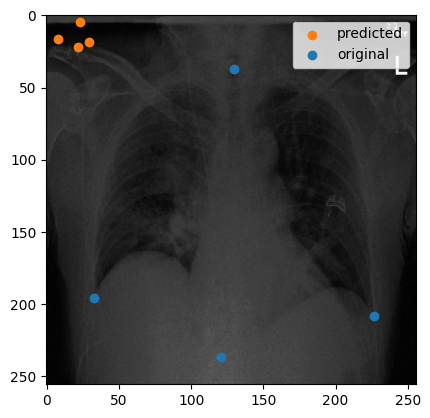

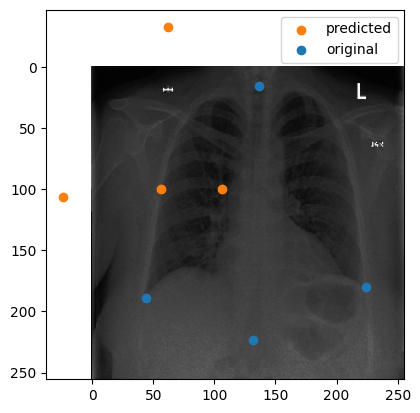

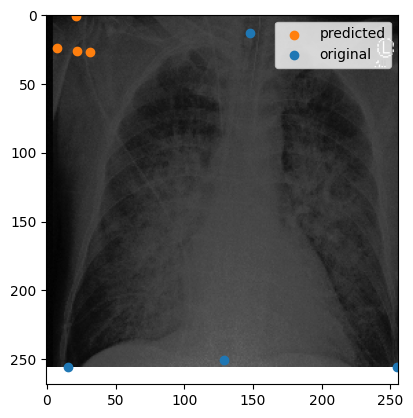

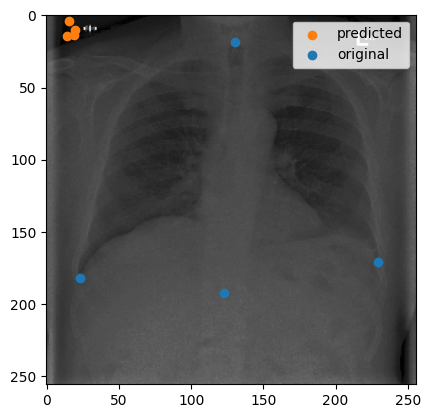

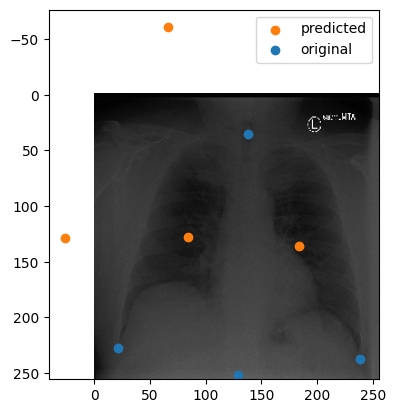

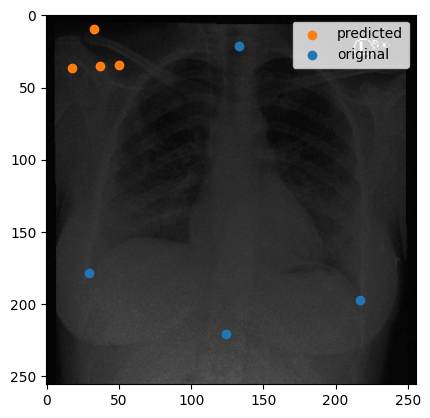

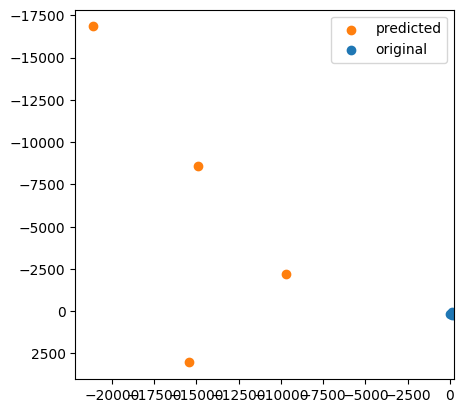

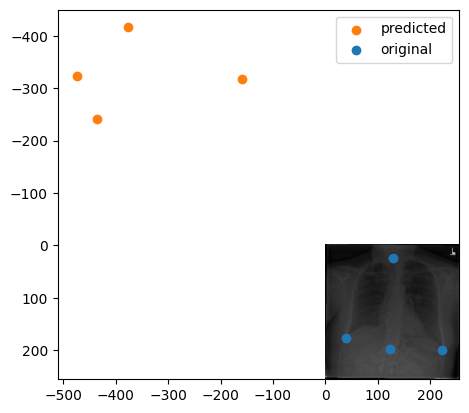

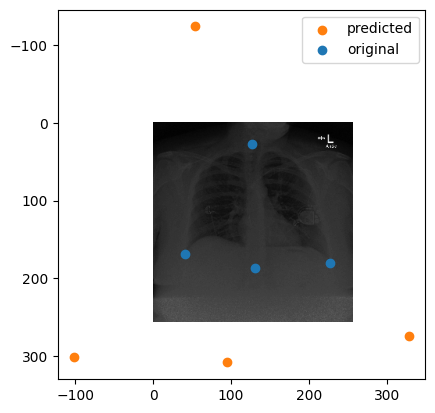

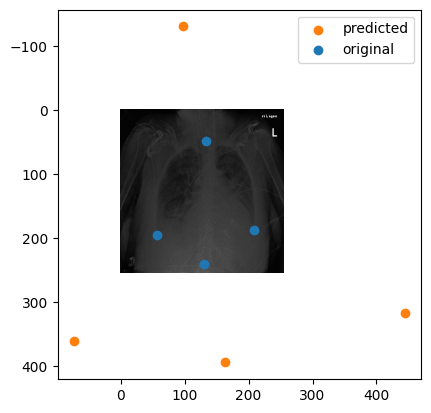

MSE: 6162842.0
Box IoU: 0.20829348368187472


In [10]:
model.eval()
loss_func = nn.MSELoss()
loss = 0
IoU = 0
for image, targ in test_loader:
        img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
        target = targ.to(DEVICE)
        pred = model(img)
        loss += loss_func(pred, target.squeeze(1))
        IoU += keypoints_IoU_mult(image, targ.squeeze(1), pred)
        pred = pred[0].to('cpu').detach().numpy()
        plt.imshow(image[0][0], cmap='gray')
        for i in range(0, 8, 2):
                scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
                scatter2 = plt.scatter(targ[0,0,i], targ[0,0,i+1], color = 'C0')
        scatter1.set_label('predicted')
        scatter2.set_label('original')
        plt.legend()
        plt.show()
print('MSE:', loss.item()/len(test_loader))
print('Box IoU:', IoU.item()/len(test_loader.dataset))

del loss, pred, IoU, target, img
torch.cuda.empty_cache()  

In [31]:
model.eval()
loss = []
for image, targ in test_loader:
        for i in range(image.shape[0]):
            img = image[i].to(device = DEVICE).unsqueeze(0).repeat(1, 3, 1, 1)
            target = targ[i].to(DEVICE)
            pred = model(img)
            loss.append(loss_func(pred, target.unsqueeze(0).squeeze(1)).item())
print(loss)
plt.hist(loss, bins = 50)

RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[1, 3, 256, 256] to have 1 channels, but got 3 channels instead

In [30]:
bigger_200 = [i for i, los in enumerate(loss) if los > 200]
bigger_200

TypeError: iteration over a 0-d tensor

In [25]:
extra_test_loader = DataLoader(test_keypoint_ds,
                    batch_size= 1,
                    num_workers= NUM_WORKERS,                      
                    pin_memory= PIN_MEMORY,
                    shuffle= False)

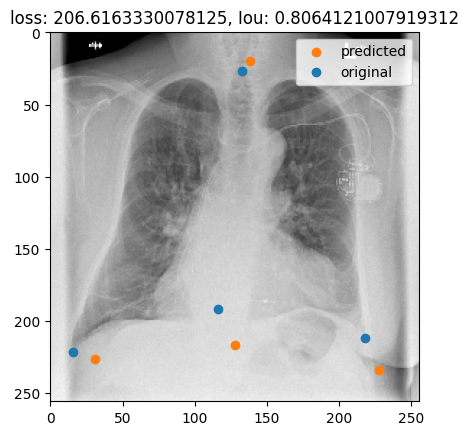

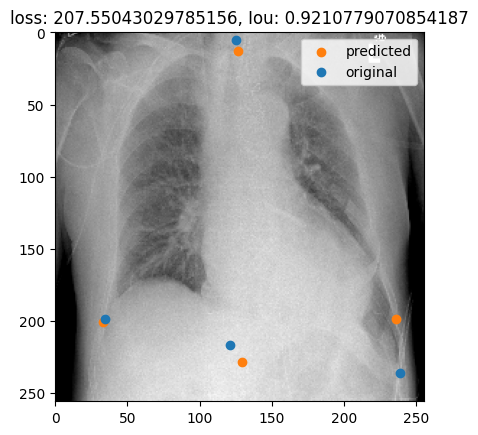

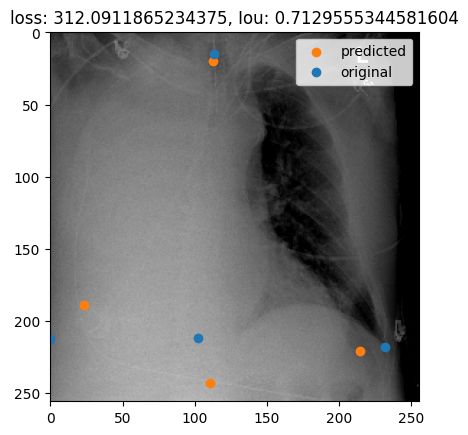

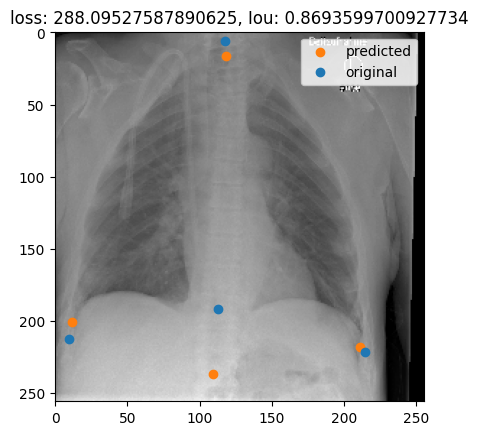

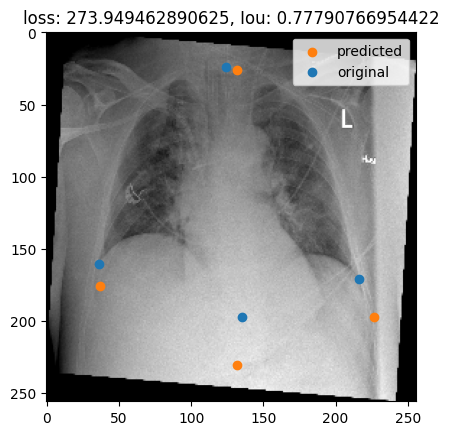

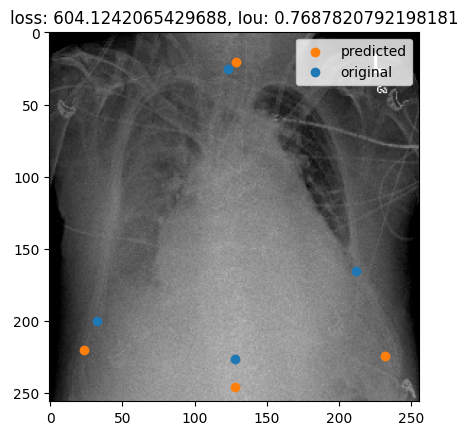

In [26]:
for i, (image, targ) in enumerate(extra_test_loader):
        if i in [40, 46, 69, 90, 124, 132]:
            img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
            target = targ.to(DEVICE)
            pred = model(img)
            loss = loss_func(pred, target.squeeze(1))
            IoU = keypoints_IoU_mult(image, targ.squeeze(1), pred)
            pred = pred[0].to('cpu').detach().numpy()
            plt.imshow(image[0][0], cmap='gray')
            for i in range(0, 8, 2):
                scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
                scatter2 = plt.scatter(targ[0,0,i], targ[0,0,i+1], color = 'C0')
            scatter1.set_label('predicted')
            scatter2.set_label('original')
            plt.title(f'loss: {loss}, Iou: {IoU}')
            plt.legend()
            plt.show()

Test check

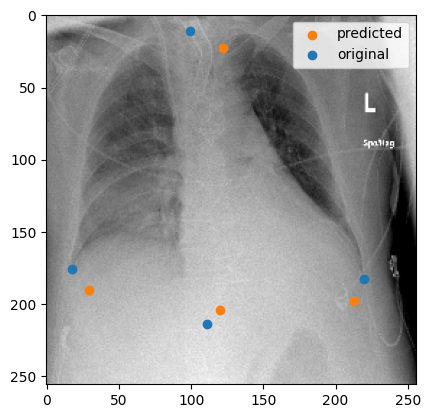

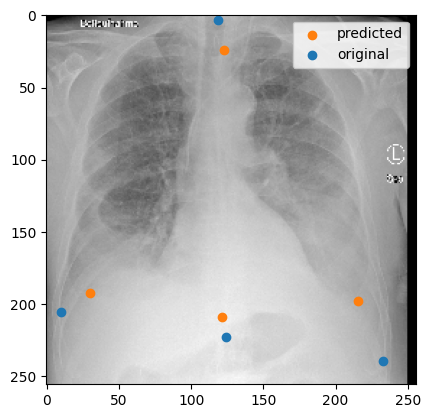

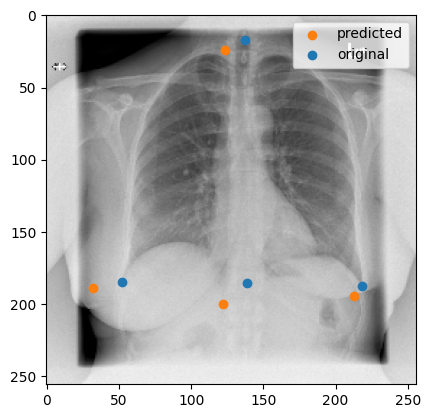

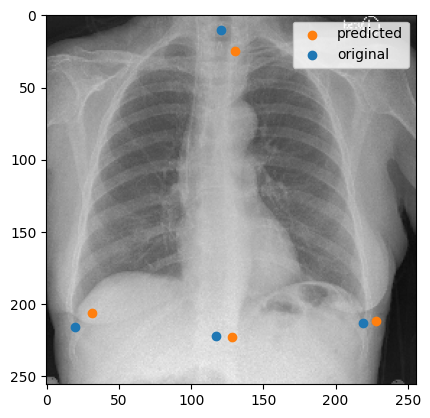

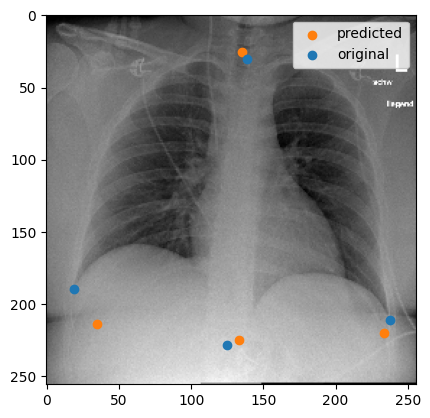

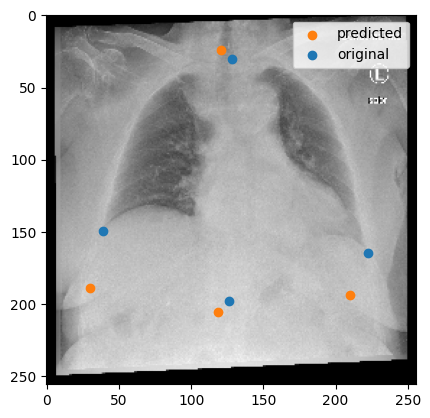

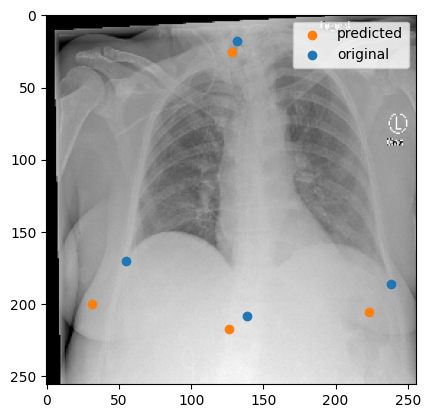

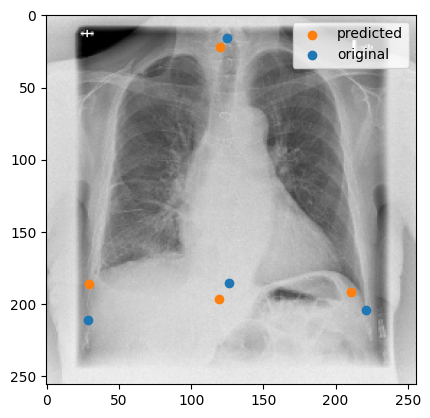

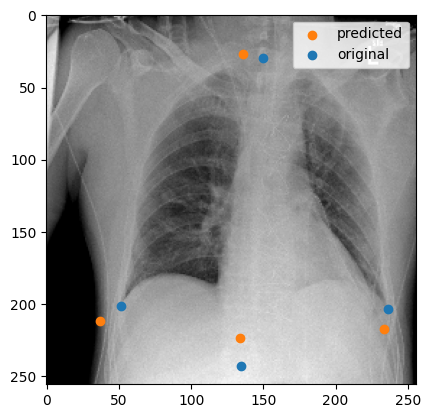

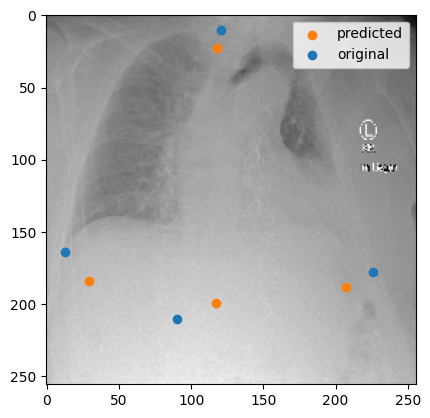

MSE: 244.073388671875
Box IoU: 0.7782710266113281
10


In [21]:
model.eval()
loss = 0
IoU = 0
for image, targ in test_loader:
        img = image.to(device = DEVICE)
        target = targ.to(DEVICE)
        pred = model(img)
        loss += loss_func(pred, target.squeeze(1))
        IoU += keypoints_IoU_mult(image, targ.squeeze(1), pred)
        pred = pred[0].to('cpu').detach().numpy()
        plt.imshow(image[0][0], cmap='gray')
        for i in range(0, 8, 2):
                scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
                scatter2 = plt.scatter(targ[0,0,i], targ[0,0,i+1], color = 'C0')
        scatter1.set_label('predicted')
        scatter2.set_label('original')
        plt.legend()
        plt.show()
print('MSE:', loss.item()/len(test_loader))
print('Box IoU:', IoU.item()/len(test_loader.dataset))

[30.755184173583984, 60.17500686645508, 15.796977043151855, 34.403594970703125, 74.68120574951172, 144.52821350097656, 80.01783752441406, 126.36607360839844, 35.76734161376953, 70.57246398925781, 71.62816619873047, 229.3328399658203, 89.29898071289062, 110.94436645507812, 122.85237121582031, 442.6134033203125, 183.4911651611328, 10.177780151367188, 38.25937271118164, 57.384239196777344, 82.656494140625, 140.98336791992188, 62.317298889160156, 134.96620178222656, 16.111427307128906, 68.78758239746094, 59.119937896728516, 188.01954650878906, 54.945579528808594, 155.4479522705078, 39.91374206542969, 46.136356353759766, 33.44084167480469, 43.711036682128906, 138.5076141357422, 66.52184295654297, 23.23168182373047, 112.71498107910156, 43.006290435791016, 39.391441345214844, 81.02529907226562, 130.68563842773438, 9.889568328857422, 71.06513977050781, 16.698246002197266, 60.288299560546875, 199.13027954101562, 66.44921875, 15.921433448791504, 38.627017974853516, 98.49449157714844, 125.1025772

(array([11.,  7., 13., 12.,  6., 13., 10., 10.,  8.,  8.,  1.,  4.,  7.,
         7.,  8.,  3.,  2.,  2.,  1.,  1.,  3.,  2.,  1.,  0.,  0.,  4.,
         1.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  8.44496059,  17.12832945,  25.8116983 ,  34.49506716,
         43.17843601,  51.86180487,  60.54517372,  69.22854258,
         77.91191143,  86.59528028,  95.27864914, 103.96201799,
        112.64538685, 121.3287557 , 130.01212456, 138.69549341,
        147.37886227, 156.06223112, 164.74559998, 173.42896883,
        182.11233768, 190.79570654, 199.47907539, 208.16244425,
        216.8458131 , 225.52918196, 234.21255081, 242.89591967,
        251.57928852, 260.26265738, 268.94602623, 277.62939508,
        286.31276394, 294.99613279, 303.67950165, 312.3628705 ,
        321.04623936, 329.72960821, 338.41297707, 347.09634592,
        355.77971478, 364.46308363, 373.14645248, 381.82982134,
        390.

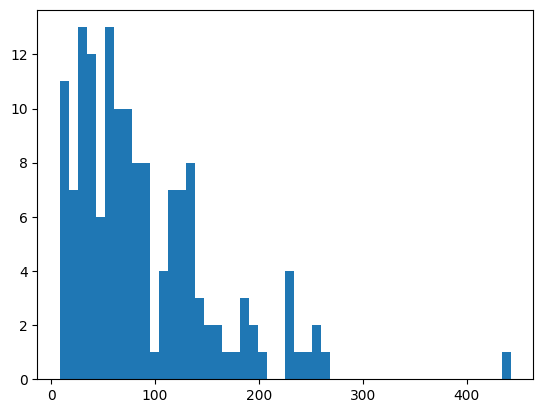

Histogram of errors

In [28]:
del loss, pred
torch.cuda.empty_cache()  

In [19]:
model.eval()
loss = []
for image, targ in test_loader:
        for i in range(image.shape[0]):
            img = image[i].to(device = DEVICE).unsqueeze(0)
            target = targ[i].to(DEVICE)
            pred = model(img)
            loss.append(loss_func(pred, target.unsqueeze(0).squeeze(1)).item())
print(loss)
plt.hist(loss, bins = 50)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 1, 256, 256] to have 3 channels, but got 1 channels instead

show example with highest loss

In [37]:
indexes = [i for i, loss in enumerate(loss) if loss > 600]

subset = Subset(test_keypoint_ds, indexes)

subset_loader = DataLoader(subset,
                          batch_size= 1,
                          num_workers= NUM_WORKERS,
                          pin_memory= PIN_MEMORY,
                          shuffle= False)

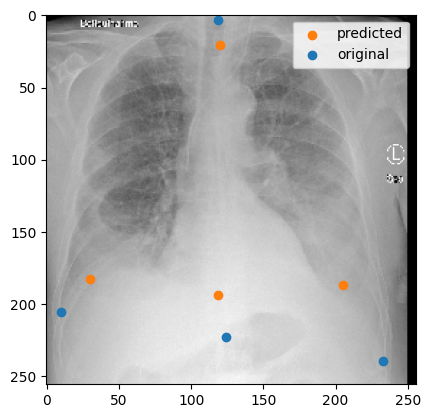

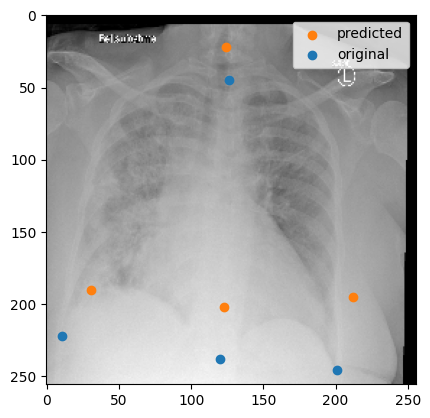

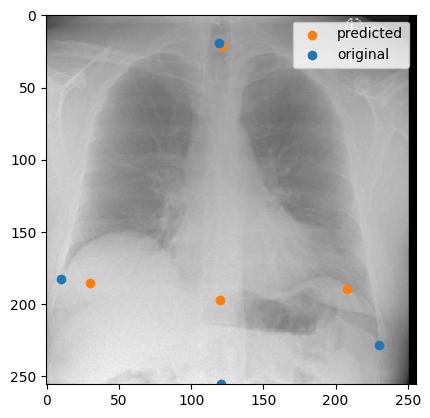

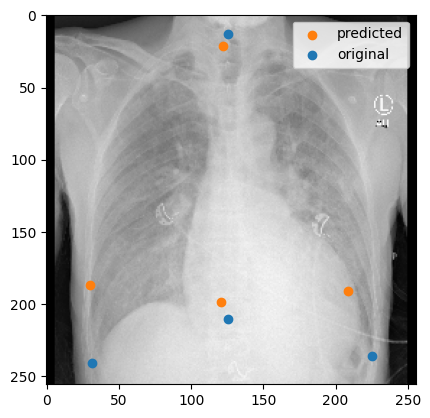

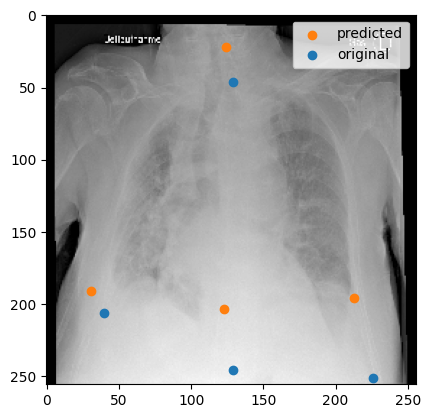

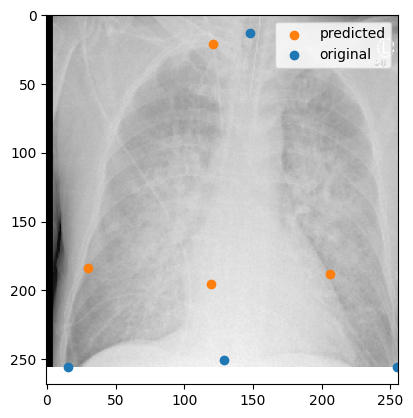

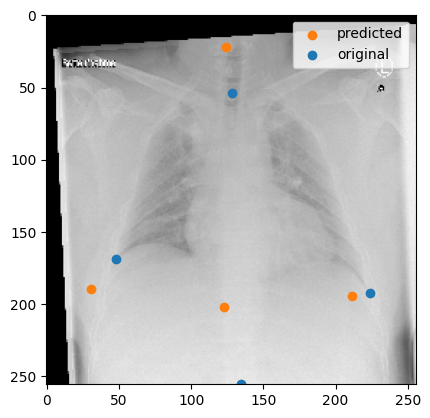

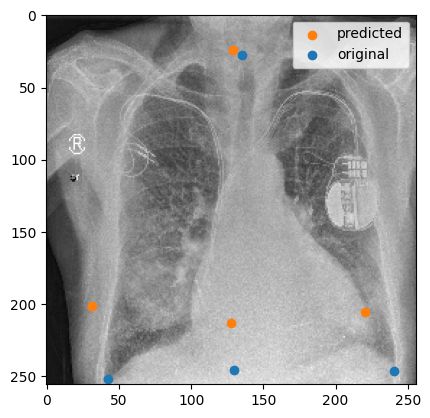

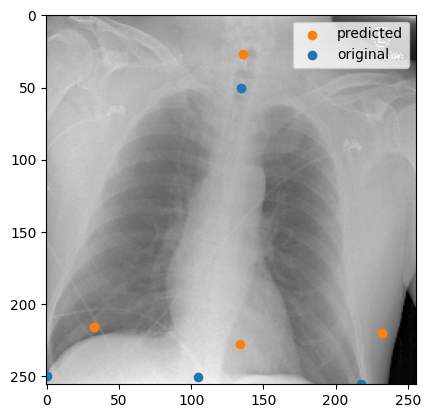

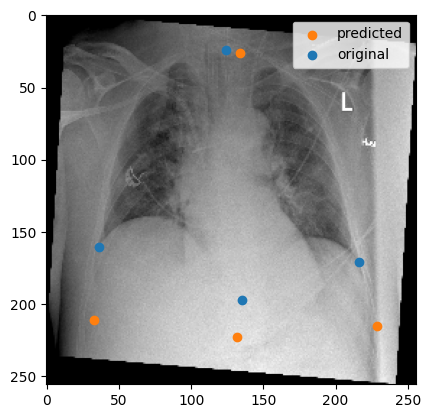

In [40]:
for image, kp in subset_loader:
    img = image.to(device = DEVICE)
    target = kp.to(DEVICE)
    pred = model(img)
    pred = pred[0].to('cpu').detach().numpy()
    plt.imshow(image[0][0], cmap='gray')
    for i in range(0, 8, 2):
        scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
        scatter2 = plt.scatter(kp[0,0,i], kp[0,0,i+1], color = 'C0')
    scatter1.set_label('predicted')
    scatter2.set_label('original')
    plt.legend()
    plt.show()

In [ ]:
from torch.utils.data import Subset

# Create a subset of the dataset using these indexes
subset = Subset(dataset, indexes)

# Create a DataLoader for this subset
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

In [56]:
test_image_path = r'/home/alex/Documents/new try/Data/Studie_daten/Bilder_stehen/image_58.png' #r'/home/alex/Documents/new try/Lung Unet/data/test/images/CHNCXR_0002_0.png'


Test acc and max error examples